In [151]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve,confusion_matrix, ConfusionMatrixDisplay, classification_report
import warnings
warnings.filterwarnings('ignore')

In [61]:
from google.colab import files
files.upload()

Saving adult.csv to adult (1).csv


{'adult (1).csv': b'age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income\r\n25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K\r\n38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K\r\n28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K\r\n44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K\r\n18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K\r\n34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K\r\n29,?,227026,HS-grad,9,Never-married,?,Unmarried,Black,Male,0,0,40,United-States,<=50K\r\n63,Self-emp-not-inc,104626,Prof-school,15,Married-civ-spouse,Pro

In [62]:
df = pd.read_csv('adult.csv')
df = df.replace('?',np.nan)
df.head(10)

age         workclass  fnlwgt     education  educational-num  \
0   25           Private  226802          11th                7   
1   38           Private   89814       HS-grad                9   
2   28         Local-gov  336951    Assoc-acdm               12   
3   44           Private  160323  Some-college               10   
4   18               NaN  103497  Some-college               10   
5   34           Private  198693          10th                6   
6   29               NaN  227026       HS-grad                9   
7   63  Self-emp-not-inc  104626   Prof-school               15   
8   24           Private  369667  Some-college               10   
9   55           Private  104996       7th-8th                4   

       marital-status         occupation   relationship   race  gender  \
0       Never-married  Machine-op-inspct      Own-child  Black    Male   
1  Married-civ-spouse    Farming-fishing        Husband  White    Male   
2  Married-civ-spouse    Protective-serv        Husband  White    Male   
3  Married-civ-spouse  Machine-op-inspct        Husband  Black    Male   
4       Never-married                NaN      Own-child  White  Female   
5       Never-married      Other-service  Not-in-family  White    Male   
6       Never-married                NaN      Unmarried  Black    Male   
7  Married-civ-spouse     Prof-specialty        Husband  White    Male   
8       Never-married      Other-service      Unmarried  White  Female   
9  Married-civ-spouse       Craft-repair        Husband  White    Male   

   capital-gain  capital-loss  hours-per-week native-country income  
0             0             0              40  United-States  <=50K  
1             0             0              50  United-States  <=50K  
2             0             0              40  United-States   >50K  
3          7688             0              40  United-States   >50K  
4             0             0              30  United-States  <=50K  
5             0             0              30  United-States  <=50K  
6             0             0              40  United-States  <=50K  
7          3103             0              32  United-States   >50K  
8             0             0              40  United-States  <=50K  
9             0             0              10  United-States  <=50K

##**SEPARATION INTO TARGET VARIABLES**

In [63]:
x = df.drop('income',axis=1)
y = df['income'].replace({'<=50K':0,'>50K':1})

##**PREPROCESSING**

In [64]:
numerical_data = x.select_dtypes(exclude='object')
categorical_data = x.select_dtypes(include='object')

In [65]:
num_pre = Pipeline([('imputer',SimpleImputer(strategy='median')),
                    ('scaler',StandardScaler())])
cat_pre = Pipeline([('imputer',SimpleImputer(strategy='most_frequent')),
                    ('encoder',OneHotEncoder(handle_unknown='ignore'))])

In [66]:
preprocessing = ColumnTransformer([('numerical',num_pre,numerical_data.columns),
                                   ('categorical',cat_pre,categorical_data.columns)])

##**TRAIN TEST SPLIT**

In [67]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)

##**BUILDING XGBOOST AS IT IS THE BEST MODEL AFTER HYPERPARAMETER TUNING**

In [89]:
def evaluate(model,x_train,x_test,y_train,y_test):
  model_pipe = Pipeline([('preprocessing',preprocessing),
                       ('model',model)])
  model_pipe.fit(x_train,y_train)
  prediction = model_pipe.predict(x_test)
  probability = model_pipe.predict_proba(x_test)[:,1]
  accuracy = accuracy_score(y_test,prediction)
  roc = roc_auc_score(y_test,probability)
  plt.figure(figsize=(7,7))
  fpr,tpr,thresholds = roc_curve(y_test,probability)
  plt.plot(fpr,tpr,color='red')
  plt.plot([0,1],[0,1],color='black',linestyle='--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC CURVE')
  plt.legend()
  plt.show()
  confusion = confusion_matrix(y_test,prediction)
  sns.heatmap(confusion,annot=True,fmt='d',cmap='Blues')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('CONFUSION MATRIX')
  return('accuracy',accuracy,
         'roc',roc)

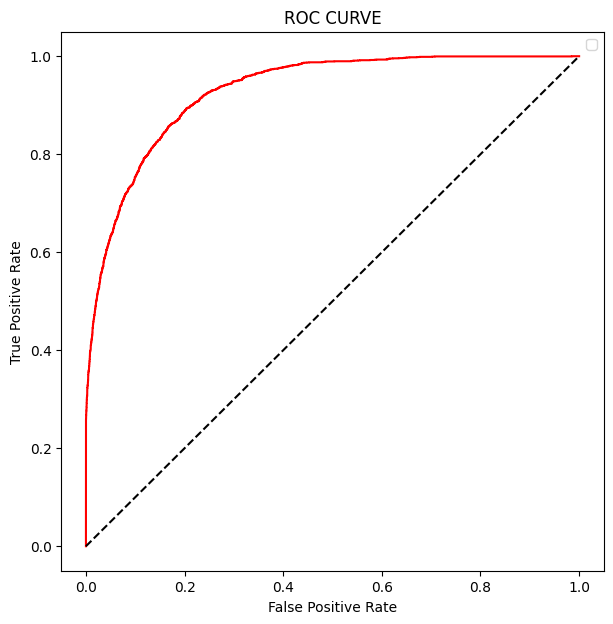

('accuracy', 0.874091513972771, 'roc', np.float64(0.9288878843040603))

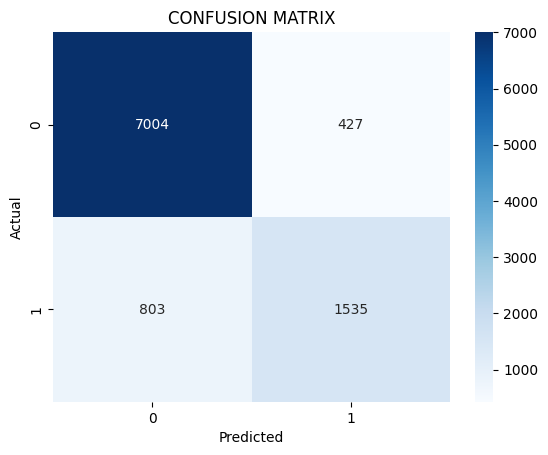

In [90]:
evaluate(XGBClassifier(eval_metric='logloss'),x_train,x_test,y_train,y_test)

##**HYPERPARAMETER TUNING**

In [91]:
from sklearn.model_selection import RandomizedSearchCV

In [92]:
param_grid = {'model__n_estimators':[100,200,300,400,500],
              'model__max_depth':[2,4,5,7],
              'model__subsample':[0.1,0.4,0.5,0.7]}

In [93]:
pipe = Pipeline([('preprocessing',preprocessing),
                 ('model',XGBClassifier(eval_metric='logloss'))])

In [104]:
search = RandomizedSearchCV(estimator=pipe,
                            param_distributions=param_grid,
                            n_iter=10,
                            n_jobs=-1,
                            random_state=42,
                            cv=3,
                            scoring='roc_auc')

In [105]:
search.fit(x_train,y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('numerical',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               Index(['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')),
                                                                              ('categorical',
                                                                               Pipeline(steps=[('imputer',...
                                                            max_delta_step=None,
                                                            max_depth=None,
                                                            max_leaves=None,
                                                            min_child_weight=None,
                                                            missing=nan,
                                                            monotone_constraints=None,
                                                            multi_strategy=None,
                                                            n_estimators=None,
                                                            n_jobs=None,
                                                            num_parallel_tree=None, ...))]),
                   n_jobs=-1,
                   param_distributions={'model__max_depth': [2, 4, 5, 7],
                                        'model__n_estimators': [100, 200, 300,
                                                                400, 500],
                                        'model__subsample': [0.1, 0.4, 0.5,
                                                             0.7]},
                   random_state=42, scoring='roc_auc')

In [106]:
best_model = search.best_estimator_

In [107]:
best_params = search.best_params_
print(best_params)

{'model__subsample': 0.5, 'model__n_estimators': 300, 'model__max_depth': 2}


In [108]:
best_score = search.best_score_
print(best_score)

0.9246996438201879


##**FEATURE EXTRACTION**

In [111]:
import shap
from sklearn.inspection import PartialDependenceDisplay

In [112]:
preprocessor = best_model.named_steps['preprocessing']
model = best_model.named_steps['model']

In [118]:
num_features = preprocessor.named_transformers_['numerical'].get_feature_names_out()
ohe = preprocessor.named_transformers_['categorical'].named_steps['encoder']
ohe_features = ohe.get_feature_names_out(preprocessor.transformers_[1][2])
all_features = np.concatenate([num_features,ohe_features])

##**FEATURE IMPORTANCE**

In [120]:
importances = model.feature_importances_
fi = pd.DataFrame({'features':all_features,'importance':importances})
fi = fi.sort_values(by='importance',ascending=False)
fi.head(20)

features  importance
32  marital-status_Married-civ-spouse    0.378026
2                     educational-num    0.064813
40         occupation_Exec-managerial    0.039766
3                        capital-gain    0.034462
44           occupation_Other-service    0.033004
0                                 age    0.018470
4                        capital-loss    0.016891
5                      hours-per-week    0.015434
6               workclass_Federal-gov    0.013620
56                  relationship_Wife    0.013135
41         occupation_Farming-fishing    0.013028
54             relationship_Own-child    0.011723
62                      gender_Female    0.011555
34       marital-status_Never-married    0.011146
89              native-country_Mexico    0.009881
61                         race_White    0.009782
46          occupation_Prof-specialty    0.009522
42       occupation_Handlers-cleaners    0.009181
11         workclass_Self-emp-not-inc    0.008723
43       occupation_Machine-op-inspct    0.008590

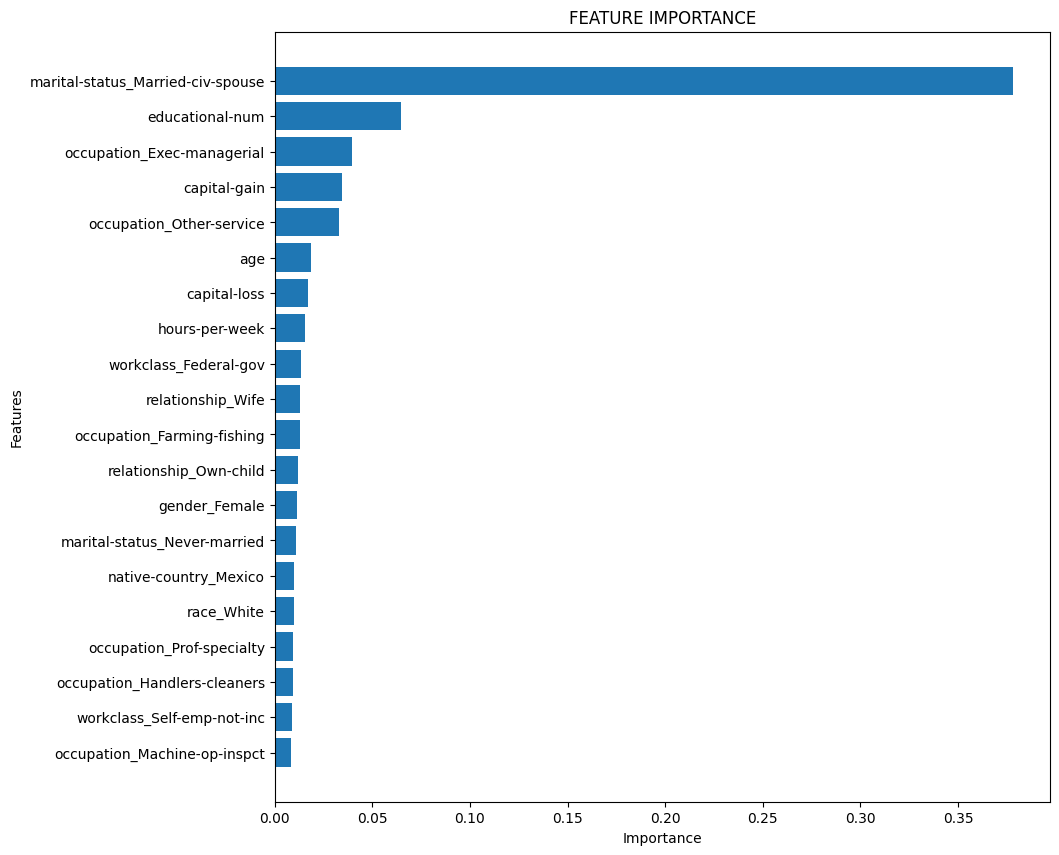

In [124]:
plt.figure(figsize=(10,10))
plt.barh(fi['features'][:20],fi['importance'][:20])
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('FEATURE IMPORTANCE')
plt.show()

##**SHAP VALUES**

In [133]:
shap.initjs()

In [134]:
x_test_transformed = preprocessor.transform(x_test)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_test_transformed)

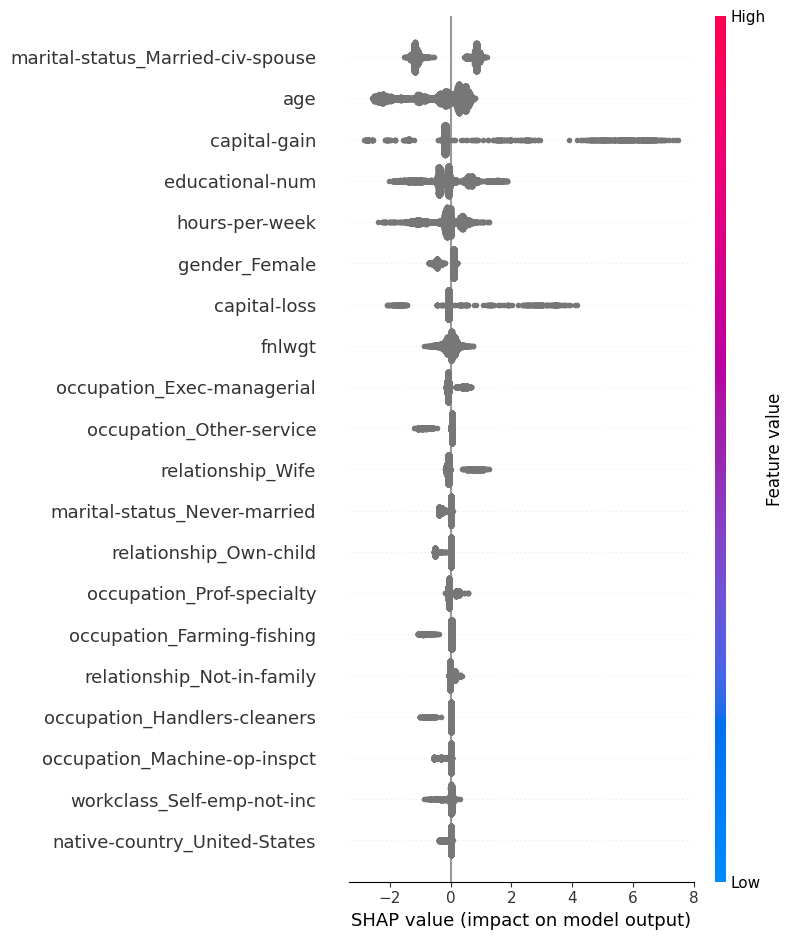

In [135]:
shap.summary_plot(shap_values,x_test_transformed,feature_names=all_features)

In [143]:
shap_html = shap.force_plot(
    explainer.expected_value,
    shap_values[10,:],
    features=all_features
)

shap.save_html("force_plot.html", shap_html)

In [145]:
from IPython.display import HTML
HTML(filename='force_plot.html')

##**ERROR ANALYSIS**

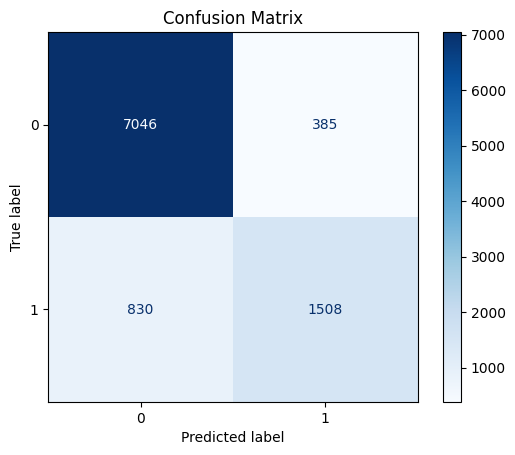

In [149]:
pred = best_model.predict(x_test)
cm = confusion_matrix(y_test, pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [154]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      7431
           1       0.78      0.66      0.71      2338

    accuracy                           0.87      9769
   macro avg       0.84      0.80      0.82      9769
weighted avg       0.87      0.87      0.87      9769



In [157]:
errors = x_test.copy()
errors['actual']=y_test
errors['predicted']=prediction
errors[errors['actual']!=errors['predicted']]
errors.head()

age  workclass  fnlwgt     education  educational-num  \
40342   54    Private  115602       HS-grad                9   
47680   28  Local-gov  401886       HS-grad                9   
524     53  Local-gov  139671  Some-college               10   
8508    58    Private  177368       HS-grad                9   
31692   47  Local-gov  352614    Assoc-acdm               12   

           marital-status       occupation    relationship   race  gender  \
40342  Married-civ-spouse    Other-service            Wife  Black  Female   
47680       Never-married     Adm-clerical  Other-relative  White    Male   
524    Married-civ-spouse  Exec-managerial         Husband  White    Male   
8508   Married-civ-spouse     Craft-repair         Husband  White    Male   
31692  Married-civ-spouse  Protective-serv         Husband  White    Male   

       capital-gain  capital-loss  hours-per-week native-country  actual  \
40342             0             0              40  United-States       0   
47680             0             0              20  United-States       0   
524               0             0              50  United-States       0   
8508           3137             0              16  United-States       0   
31692             0             0              40  United-States       1   

       predicted  
40342          0  
47680          0  
524            1  
8508           0  
31692          1

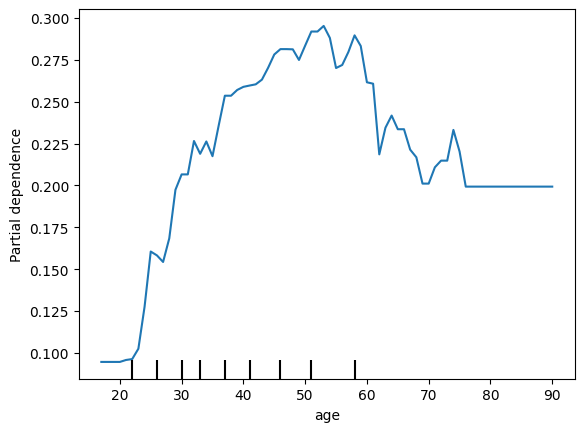

In [173]:
PartialDependenceDisplay.from_estimator(
    best_model,
    x_train,
    features=['age'],
)
plt.show()

### Final Model Selection

Based on ROC-AUC, interpretability, and overall stability:

**Selected Model:** XGBoost

**Reason:**
- Highest ROC-AUC = 0.92
- Better precision–recall balance
- Interpretability validated using SHAP
- Stable performance across folds
- No major signs of overfitting
